##PointNet 2 (or PointNet++) for Object Classification and Part Segmentation Using the ScanObjectNN Dataset

**Scientific Simulation 1**
**Team Members:**

Hossein Asgaribakhtiari

Mridul Bhattarai

George Ayobami Thomas

## 1.1) Mounting Drive

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


## 1.2) Cloning Git repository for PointNet 2

In [2]:
#Cloning Git Repository
!git clone https://github.com/yanx27/Pointnet_Pointnet2_pytorch
!cd Pointnet_Pointnet2_pytorch

Cloning into 'Pointnet_Pointnet2_pytorch'...
remote: Enumerating objects: 842, done.
remote: Total 842 (delta 0), reused 0 (delta 0), pack-reused 842 (from 1)
Receiving objects: 100% (842/842), 68.77 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (485/485), done.


## 1.3) Specifying home directory

In [3]:
home = '/content/Pointnet_Pointnet2_pytorch'

import os
os.chdir(home)

##1.4) Install the package in editable mode

## 1.5) Build C++ code for visualization

* Before downloading the dataset, we first update the dataset link in the download.sh file. The dataset is extracted into a folder named 'object_dataset_complete_with_parts ', which contains an unintended trailing space. This extra space can cause issues when working with file paths, so we rename the folder to remove the trailing space for smoother processing.

## 1.6) Edit download.sh file to download a different (ScanObjectNN) dataset

In [6]:
import os

# New dataset link with %20 for URL space
new_wget_link = "https://hkust-vgd.ust.hk/scanobjectnn/raw/object_dataset_complete_with_parts%20.zip"

# Actual zip file name (with literal space)
new_zip_name = "object_dataset_complete_with_parts .zip"

# Proper shell-safe version of the filename (wrapped in quotes)
new_zip_name_shell = f'"{new_zip_name}"'

# New safe file name (without space)
safe_zip_name = "object_dataset_complete_with_parts.zip"
safe_zip_name_shell = f'"{safe_zip_name}"'

# Path to the original file
original_file = "/content/Pointnet_Pointnet2_pytorch/scripts/download.sh"

# Check if file exists
if not os.path.exists(original_file):
    raise FileNotFoundError(f"File not found: {original_file}")

# Read original lines
with open(original_file, 'r') as f:
    lines = f.readlines()

# Replace wget line and any zip file references — also insert mv command after wget
edited_lines = []
for i, line in enumerate(lines):
    stripped = line.strip()
    if stripped.startswith("wget "):
        # Replace wget line
        edited_lines.append(f"wget {new_wget_link} --no-check-certificate\n")
        # Insert mv line right after
        edited_lines.append(f"mv {new_zip_name_shell} {safe_zip_name_shell}\n")
    elif "shapenetcore_partanno_segmentation_benchmark_v0.zip" in line:
        # Replace old zip name references with new safe zip name
        edited_lines.append(line.replace("shapenetcore_partanno_segmentation_benchmark_v0.zip", safe_zip_name))
    else:
        edited_lines.append(line)

# Write back the updated file
with open(original_file, 'w') as f:
    f.writelines(edited_lines)

print(f"\n✅ Updated {original_file} successfully with mv and safe zip handling.")






✅ Updated /content/Pointnet_Pointnet2_pytorch/scripts/download.sh successfully with mv and safe zip handling.


## 1.7) Download dataset

In [7]:
!bash {home}/scripts/download.sh

Streaming output truncated to the last 5000 lines.
  inflating: object_dataset_complete_with_parts /shelf/201_00002.bin  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00025_part.xml  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00025_part.bin  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00019_part.xml  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00019_part.bin  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00018_part.xml  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00018_part.bin  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00013_part.xml  
  inflating: object_dataset_complete_with_parts /shelf/scene0646_00_00013_part.bin  
  inflating: object_dataset_complete_with_parts /shelf/scene0645_00_00025_part.xml  
  inflating: object_dataset_complete_with_parts /shelf/scene0645_00_00025_part.bin  
  inflating: object_dataset_

In [ ]:
%mv /content/pointnet.pytorch/object_dataset_complete_with_parts* /content/pointnet.pytorch/object_dataset_complete_with_parts

# 1.8) Preparing Dataset
Now that the dataset has been downloaded, we need to put a ".py" file at "/content/Pointnet_Pointnet2_pytorch" and modify it accordingly to "/content/Pointnet_Pointnet2_pytorch/pointnet2/dataset2.py" in our Colab environment. This file handles all data preparation tasks for both classification and part segmentation. So, what we are doing here is replacing the old code used in pointnet with our new code to the file dataset2.py for pointnet 2.

In [8]:
dataset_file_path="/content/Pointnet_Pointnet2_pytorch/pointnet2/dataset2.py"

new_code="""
from __future__ import print_function
import torch.utils.data as data
import pandas as pd
import os
import os.path
import torch
import numpy as np
import sys
from tqdm import tqdm
import json

SCANOBJECTNN_CLASSES = {
    0: "bag",
    1: "bin",
    2: "box",
    3: "cabinet",
    4: "chair",
    5: "desk",
    6: "display",
    7: "door",
    8: "shelf",
    9: "table",
    10: "bed",
    11: "pillow",
    12: "sink",
    13: "sofa",
    14: "toilet"
}

root="/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts"

def get_segmentation_classes(root, split='train'):
    split_file = os.path.join(root, 'split_new.txt')
    cat = {}   # Mapping from file name to class id (based on split)
    meta = {}
    datapath = []  # Collects (class_id, point_path, seg_path)

    with open(split_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            filename = parts[0]
            class_id = parts[1]
            cat[filename] = class_id # 038_00032.bin =	0 (0 is bag)

    for filename in cat:
        class_id = int(cat[filename])
        print (class_id)
        class_name = SCANOBJECTNN_CLASSES[class_id]
        class_dir = os.path.join(root, class_name)
        meta[filename] = []

        token = os.path.splitext(filename)[0]
        point_path = os.path.join(class_dir, token + '.bin')
        seg_path = os.path.join(class_dir, token + '_part.bin')

        meta[filename].append((point_path, seg_path))
        datapath.append((class_id, point_path, seg_path))

    # Track max part labels per class_id
    class_max_seg = {}

    for point_path, seg_path in meta[filename]:
        try:
            raw = np.fromfile(seg_path, dtype=np.float32)[1:]  # Skip first entry
            if len(raw) % 2 != 0:
                raise ValueError(f"Malformed data in {seg_path}")
            labels = pd.DataFrame(raw.reshape(-1, 2), columns=["point_number", "label"])['label']
            num_parts = len(np.unique(labels))
            class_max_seg[class_id] = max(class_max_seg.get(class_id, 0), num_parts)
        except Exception as e:
            print(f"Error in {seg_path}: {e}")

    # Write and print results in order of class_id
    output_file = os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/num_seg_classes.txt')
    with open(output_file, 'w') as f:
        for class_id in sorted(class_max_seg):
            class_name = SCANOBJECTNN_CLASSES[class_id]
            max_parts = class_max_seg[class_id]
            print(f"category {class_name} has {max_parts} part segmentation classes")
            f.write(f"{class_name}	{max_parts}")


def gen_modelnet_id(root):
    split_file = os.path.join(root, 'split_new.txt')
    class_ids = set()

    with open(split_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_ids.add(int(parts[1]))

    output_file = os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/modelnet_id.txt')
    with open(output_file, 'w') as f:
        for class_id in sorted(class_ids):
            class_name = SCANOBJECTNN_CLASSES[class_id]
            f.write(f"{class_name}	{class_id}")

class ScanObjectNN_PartSeg(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2500,
                 classification=False,
                 class_choice=None,
                 split='train',
                 data_augmentation=True):
        self.npoints = npoints
        self.root = root
        self.data_augmentation = data_augmentation
        self.classification = classification
        self.seg_classes = {}
        self.cat = {}
        self.all_unique_parts = set()


        # Load split file and filter based on split and class_choice
        split_file = os.path.join(root, 'split_new.txt')
        with open(split_file, 'r') as f:
            lines = [line.strip().split() for line in f.readlines()]
        for parts in lines:
            filename = parts[0]
            class_id1 = int(parts[1])
            # Handle split logic based on presence of third column
            if split == 'test':
                if len(parts) < 3:
                    continue  # Skip if 't' is not present for test
            elif split == 'train':
                if len(parts) >= 3:
                    continue  # Skip if 't' is present for train
            class_name1 = SCANOBJECTNN_CLASSES[class_id1]

            if class_choice is not None and class_name1 not in class_choice:
                continue
            self.cat[filename] = class_id1

        # Build meta dictionary
        self.meta = {}
        self.datapath= []
        for filename in self.cat:
            class_id2 = self.cat[filename]
            class_name2 = SCANOBJECTNN_CLASSES[class_id2]
            token = os.path.splitext(filename)[0]
            class_dir = os.path.join(root, class_name2)
            point_path = os.path.join(class_dir, token + '.bin')
            seg_path = os.path.join(class_dir, token + '_part.bin')
            if filename not in self.meta:
                self.meta[filename] = []
            self.meta[filename].append((point_path, seg_path))
            self.datapath.append((class_name2, point_path, seg_path))


        max_parts = 0
        all_unique_parts = set()  # To collect all unique part labels across files

        for filename in self.meta:
            class_id2 = self.cat[filename]
            class_name2 = SCANOBJECTNN_CLASSES[class_id2]

            # Directly get the single tuple (point_path, seg_path)
            point_path, seg_path = self.meta[filename][0]

            try:
                raw = np.fromfile(seg_path, dtype=np.float32)[1:]  # Skip first entry
                if len(raw) % 2 != 0:
                    raise ValueError(f"Malformed data in {seg_path}")

                labels = pd.DataFrame(raw.reshape(-1, 2), columns=["point_number", "label"])['label']
                unique_labels = np.unique(labels).astype(int)

                all_unique_parts.update(unique_labels)
                num_unique_labels = len(np.unique(labels))
                max_parts = max(max_parts, num_unique_labels)

            except Exception as e:
                print(f"Error in {seg_path}: {e}")
        self.num_seg_classes = max_parts
        self.all_unique_parts = sorted(all_unique_parts)

    def __len__(self):
        return len(self.datapath)

    def __getitem__(self, index):
        # Get class ID, and paths to point cloud and segmentation files
        class_id, point_path, seg_path = self.datapath[index]

        # Load the point cloud (skip the first float, then reshape)
        point_raw = np.fromfile(point_path, dtype=np.float32)[1:].reshape(-1, 11)
        point_set = point_raw[:, :3]  # Only keep x, y, z

        # Load segmentation labels (skip first float, then reshape)
        seg_raw = np.fromfile(seg_path, dtype=np.float32)[1:].reshape(-1, 2)
        seg = seg_raw[:, 1].astype(np.int64)  # Use label column

        # Subsample or duplicate points to match self.npoints
        if len(seg) < self.npoints:
            choice = np.random.choice(len(seg), self.npoints, replace=True)
        else:
            choice = np.random.choice(len(seg), self.npoints, replace=False)

        point_set = point_set[choice, :]
        seg = seg[choice]

        # Convert to PyTorch tensors
        point_set = torch.from_numpy(point_set.astype(np.float32))
        seg = torch.from_numpy(seg.astype(np.int64))

        if self.classification:
            # Map class_id to integer label
            class_name = SCANOBJECTNN_CLASSES[class_id]
            cls = self.classes[class_name]
            return point_set, cls
        else:
            return point_set, seg


class ScanObjectNN_Classify(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2048,
                 split='train',
                 split_file='split_new.txt',
                 data_augmentation=True):
        self.root = root
        self.npoints = npoints
        self.split = split
        self.data_augmentation = data_augmentation
        self.fns = []
        self.labels = []
        self.cat = SCANOBJECTNN_CLASSES
        self.classes = SCANOBJECTNN_CLASSES


        split_path = os.path.join(root, split_file)
        with open(split_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                filename = parts[0]
                class_id = int(parts[1])
                # Handle split logic based on presence of third column
                if split == 'test':
                    if len(parts) < 3 or parts[2] != 't':
                        continue  # Skip if 't' is not present for test
                elif split == 'train':
                    if len(parts) >= 3 and parts[2] == 't':
                        continue  # Skip if 't' is present for train
                class_name = self.cat[class_id]
                rel_path = os.path.join(class_name, filename)
                self.fns.append(rel_path)
                self.labels.append(class_id)

        print(f"[{split.upper()}] Loaded {len(self.fns)} samples.")

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, index):
        rel_path = self.fns[index]
        label = self.labels[index]
        full_path = os.path.join(self.root, rel_path)

        raw_data = np.fromfile(full_path, dtype=np.float32)
        point_data = raw_data[1:].reshape(-1, 11)  # remove first point (1 floats), reshape
        pointcloud = point_data[:, :3]  # keep only XYZ


        # Sample or pad
        if pointcloud.shape[0] >= self.npoints:
            idx = np.random.choice(pointcloud.shape[0], self.npoints, replace=False)
        else:
            idx = np.random.choice(pointcloud.shape[0], self.npoints, replace=True)
        pointcloud = pointcloud[idx]

        # Center and scale
        pointcloud = pointcloud - np.mean(pointcloud, axis=0, keepdims=True)
        scale = np.max(np.sqrt(np.sum(pointcloud ** 2, axis=1)))
        pointcloud = pointcloud / scale

        # Augmentation
        if self.data_augmentation:
            theta = np.random.uniform(0, 2 * np.pi)
            rot_mat = np.array([
                [np.cos(theta), 0, -np.sin(theta)],
                [0, 1, 0],
                [np.sin(theta), 0, np.cos(theta)]
            ])
            pointcloud = pointcloud @ rot_mat
            pointcloud += np.random.normal(0, 0.02, size=pointcloud.shape)

        return pointcloud.astype(np.float32), np.array(label, dtype=np.int64)


if __name__ == '__main__':
    dataset = sys.argv[1]
    datapath = sys.argv[2]

    if dataset == 'ScanObjectNN_PartSeg':
        d = ScanObjectNN_PartSeg(root=datapath, class_choice=['chair'])
        print(len(d))
        ps, seg = d[0]
        print(ps.shape, ps.dtype, seg.shape, seg.dtype)

        d = ScanObjectNN_PartSeg(root=datapath, classification=True)
        print(len(d))
        ps, cls = d[0]
        print(ps.shape, ps.dtype, cls.shape, cls.dtype)

    if dataset == 'ScanObjectNN_Classify':
        dataset_obj = ScanObjectNN_Classify(root=datapath)

        print(f"Loaded {len(dataset_obj)} samples from ScanObjectNN for classification.")

        # Fetch the first sample (point cloud and class label)
        pointcloud, label = dataset_obj[0]

        print(f"Point cloud shape in first sample: {pointcloud.shape}, dtype: {pointcloud.dtype}")
        print(f"Label shape in first sample: {label.shape}, dtype: {label.dtype}")


"""
# Check if the file exists before writing
if os.path.exists(dataset_file_path):
    with open(dataset_file_path, 'w') as f:
        f.write(new_code)
    print(f"Updated {dataset_file_path} with new code.")
else:
    print(f"Error: The file {dataset_file_path} does not exist.")


Updated /content/Pointnet_Pointnet2_pytorch/pointnet2/dataset2.py with new code.


## 1.9) Classification: Train, Test, and Plot Results

The code below replaces the train_classification file with our custom implementation for training and testing on the ScanObjectNN dataset (tcp2). It also saves the training and testing results as images, which we will display later in the notebook.

In [18]:
train_classification_file_path="/content/Pointnet_Pointnet2_pytorch/tcp2.py"
new_train_code="""
from __future__ import print_function
import torch.utils.data as data
import os
import random
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import glob
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from pointnet2.dataset2 import ScanObjectNN_Classify
from pointnet2.pointnet2_cls_ssg_3 import get_model as PointNet2Cls, feature_transform_regularizer

# Argument parsing
parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=32)
parser.add_argument('--num_points', type=int, default=2048)
parser.add_argument('--workers', type=int, default=4)
parser.add_argument('--nepoch', type=int, default=250)
parser.add_argument('--outf', type=str, default='cls_pointnet2')
parser.add_argument('--model', type=str, default='')
parser.add_argument('--dataset', type=str, required=True)
parser.add_argument('--dataset_type', type=str, default='ScanObjectNN_Classify')
parser.add_argument('--feature_transform', action='store_true')
parser.add_argument('--lr', type=float, default=0.001)
opt = parser.parse_args()

print(opt)
blue = lambda x: '\033[94m' + x + '\033[0m'
opt.manualSeed = 42
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

# Load dataset
if opt.dataset_type == 'ScanObjectNN_Classify':
    dataset = ScanObjectNN_Classify(root=opt.dataset, split='train', npoints=opt.num_points)
    test_dataset = ScanObjectNN_Classify(root=opt.dataset, split='test', npoints=opt.num_points, data_augmentation=False)
else:
    raise ValueError(f"Unsupported dataset type: {opt.dataset_type}")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt.batchSize, shuffle=True, num_workers=int(opt.workers))

print("Number of Train Dataset :", len(dataset), "; Number of Test Dataset :", len(test_dataset))
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

os.makedirs(opt.outf, exist_ok=True)
results_dir = "classification_results"
os.makedirs(results_dir, exist_ok=True)

classifier = PointNet2Cls(num_classes=num_classes, feature_transform=opt.feature_transform)
if opt.model != '':
    classifier.load_state_dict(torch.load(opt.model))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)
optimizer = optim.Adam(classifier.parameters(), lr=opt.lr, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_accuracies, test_accuracies = [], []
num_batch = len(dataloader)

for epoch in range(opt.nepoch):
    classifier.train()
    epoch_train_correct = 0
    total_train_samples = 0
    all_train_preds, all_train_labels = [], []

    for i, data in enumerate(dataloader, 0):
        points, target = data
        points = points.transpose(2, 1).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        pred, trans_feat = classifier(points)
        loss = F.nll_loss(pred, target)
        if opt.feature_transform:
            loss += feature_transform_regularizer(trans_feat) * opt.lr
        loss.backward()
        optimizer.step()

        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        epoch_train_correct += correct.item()
        total_train_samples += target.size(0)
        all_train_preds.append(pred_choice.cpu().numpy())
        all_train_labels.append(target.cpu().numpy())

        print('[%d: %d/%d] train loss: %f accuracy: %f' % (epoch, i, num_batch, loss.item(), correct.item() / float(opt.batchSize)))

    train_accuracy = epoch_train_correct / total_train_samples
    train_accuracies.append(train_accuracy)

    classifier.eval()
    epoch_test_correct = 0
    total_test_samples = 0
    with torch.no_grad():
        for data in testdataloader:
            points, target = data
            points = points.transpose(2, 1).to(device)
            target = target.to(device)
            pred, trans_feat = classifier(points)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            epoch_test_correct += correct.item()
            total_test_samples += target.size(0)

    test_accuracy = epoch_test_correct / total_test_samples
    test_accuracies.append(test_accuracy)

    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    cm = confusion_matrix(all_train_labels, all_train_preds)
    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Epoch {epoch}')
    cf_plot_path = os.path.join(results_dir, f"Confusion_Matrix{epoch}.png")
    plt.savefig(cf_plot_path)
    plt.close()

    print(f"Epoch {epoch} Summary: Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")

    torch.save(classifier.state_dict(), f'{opt.outf}/cls_model_{epoch}.pth')

# Plot accuracy curves
plt.figure(figsize=(10, 6))
epochs = range(len(train_accuracies))
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, marker='s', label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Epoch')
plt.xlim(left=0)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plot_path = os.path.join(results_dir, "test_train_accuracy_classification.png")
plt.savefig(plot_path)
plt.close()
print(f"Accuracy plot saved at: {plot_path}")
"""

# Check if the file exists before writing
if os.path.exists(train_classification_file_path):
    with open(train_classification_file_path, 'w') as f:
        f.write(new_train_code)
    print(f"Updated {train_classification_file_path} with new code.")
else:
    print(f"Error: The file {train_classification_file_path} does not exist.")

Updated /content/Pointnet_Pointnet2_pytorch/tcp2.py with new code.


## 2) Training Logs and Results
**Hyperparameter Configuration 1:**

Number of epochs: 10

Learning rate: 0.001

Batch size: 32

Number of points sampled: 2000

In [11]:
%pwd

'/content/Pointnet_Pointnet2_pytorch'

In [24]:
!python "/content/Pointnet_Pointnet2_pytorch/tcp2.py" \
  --dataset "/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts" \
  --nepoch 10 \
  --dataset_type ScanObjectNN_Classify \
  --num_points 2000 \
  --lr 0.001 \
  --batchSize 32


Namespace(batchSize=32, num_points=2000, workers=4, nepoch=10, outf='cls_pointnet2', model='', dataset='/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts', dataset_type='ScanObjectNN_Classify', feature_transform=False, lr=0.001)
[TRAIN] Loaded 2319 samples.
[TEST] Loaded 583 samples.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Number of Train Dataset : 2319 ; Number of Test Dataset : 583
Number of classes: 15
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our sugge

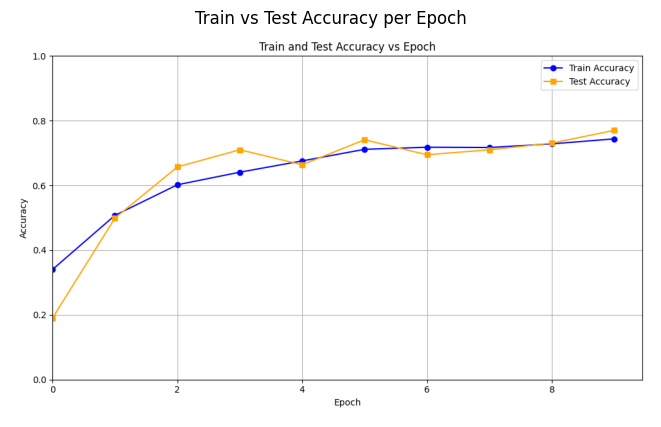

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected image path
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/test_train_accuracy_classification.png'

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Train vs Test Accuracy per Epoch")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")



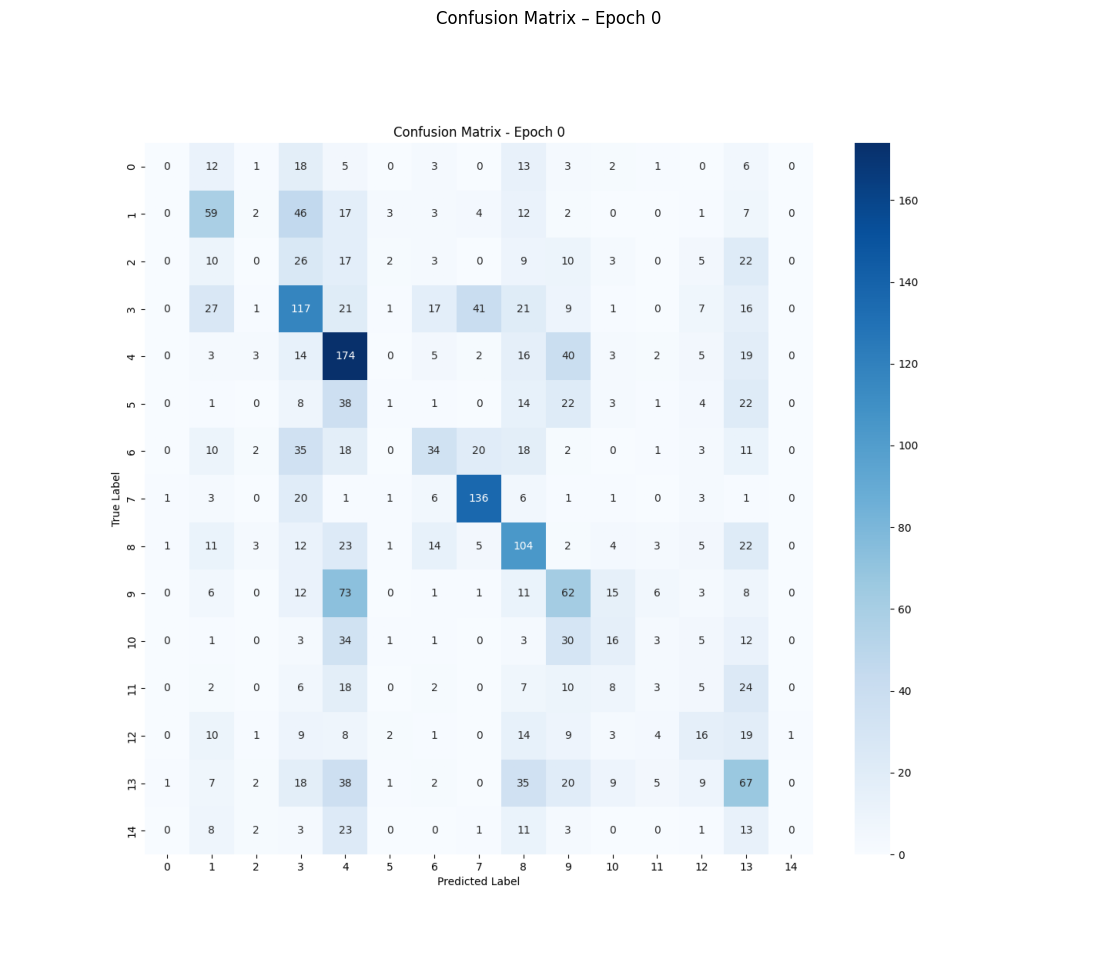

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected image path (no pointnet.pytorch, use current working directory)
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/Confusion_Matrix0.png'

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(14, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix – Epoch 0")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")

**Hyperparameter Configuration 2:**

Number of epochs: 10

Learning rate: 0.003

Batch size: 32

Number of points sampled: 2000

In [27]:
!python "/content/Pointnet_Pointnet2_pytorch/tcp2.py" \
  --dataset "/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts" \
  --nepoch 10 \
  --dataset_type ScanObjectNN_Classify \
  --num_points 2000 \
  --lr 0.003 \
  --batchSize 32

Namespace(batchSize=32, num_points=2000, workers=4, nepoch=10, outf='cls_pointnet2', model='', dataset='/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts', dataset_type='ScanObjectNN_Classify', feature_transform=False, lr=0.003)
[TRAIN] Loaded 2319 samples.
[TEST] Loaded 583 samples.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Number of Train Dataset : 2319 ; Number of Test Dataset : 583
Number of classes: 15
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our sugge

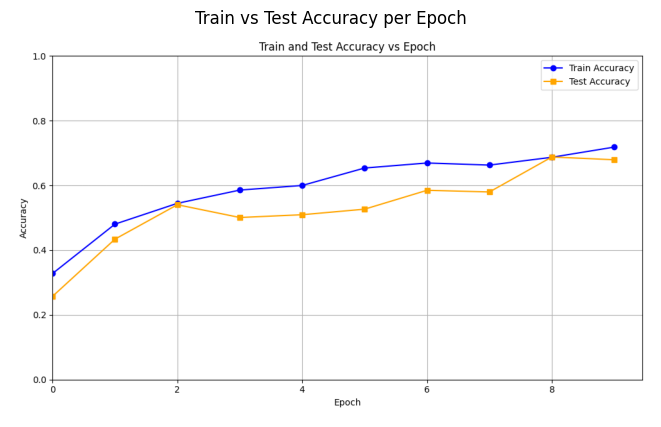

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected absolute path based on your project structure
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/test_train_accuracy_classification.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Train vs Test Accuracy per Epoch")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")


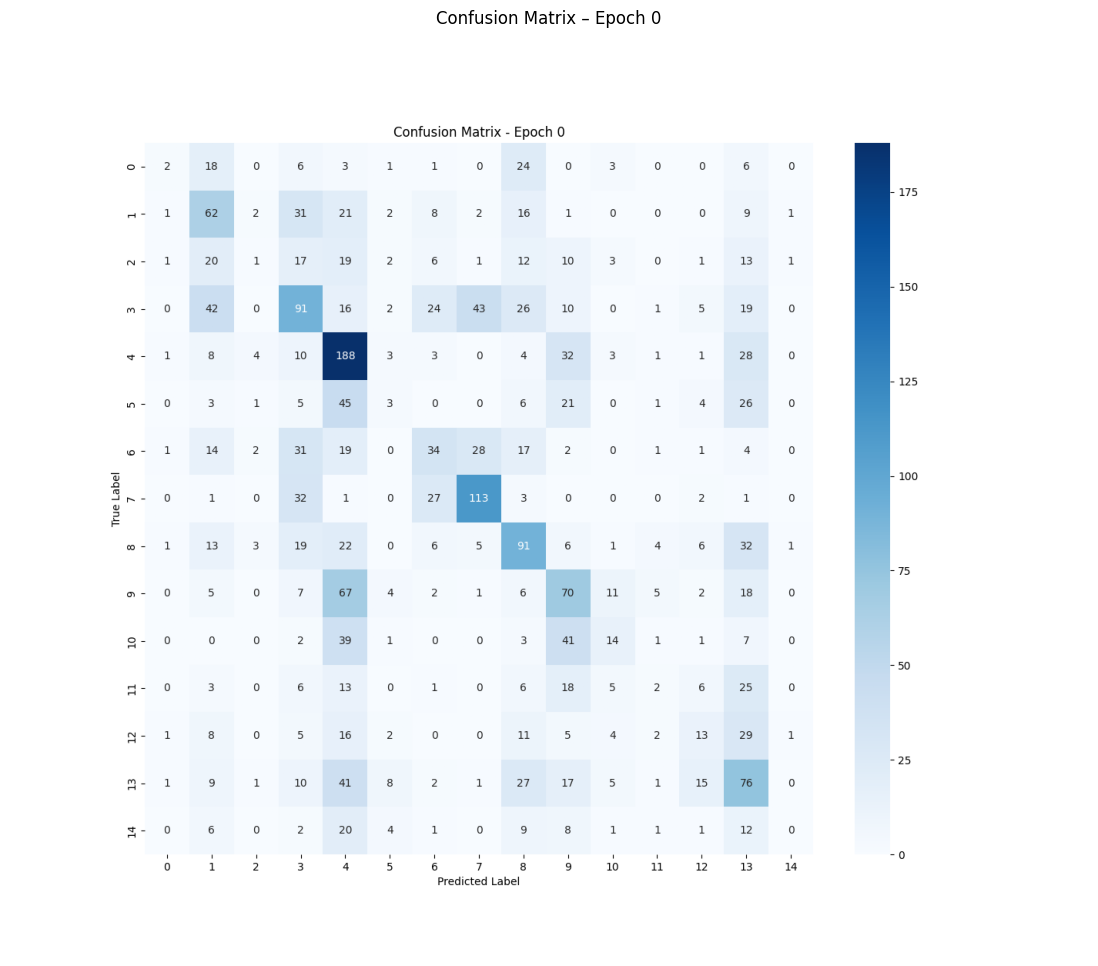

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected image path based on actual saved location
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/Confusion_Matrix0.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(16, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix – Epoch 0")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")


**Hyperparameter Configuration 3:**

Number of epochs: 10

Learning rate: 0.001

Batch size: 64

Number of points sampled: 2000

In [30]:
!python "/content/Pointnet_Pointnet2_pytorch/tcp2.py" \
  --dataset "/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts" \
  --nepoch 10 \
  --dataset_type ScanObjectNN_Classify \
  --num_points 2000 \
  --lr 0.001 \
  --batchSize 64

Namespace(batchSize=64, num_points=2000, workers=4, nepoch=10, outf='cls_pointnet2', model='', dataset='/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts', dataset_type='ScanObjectNN_Classify', feature_transform=False, lr=0.001)
[TRAIN] Loaded 2319 samples.
[TEST] Loaded 583 samples.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Number of Train Dataset : 2319 ; Number of Test Dataset : 583
Number of classes: 15
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our sugge

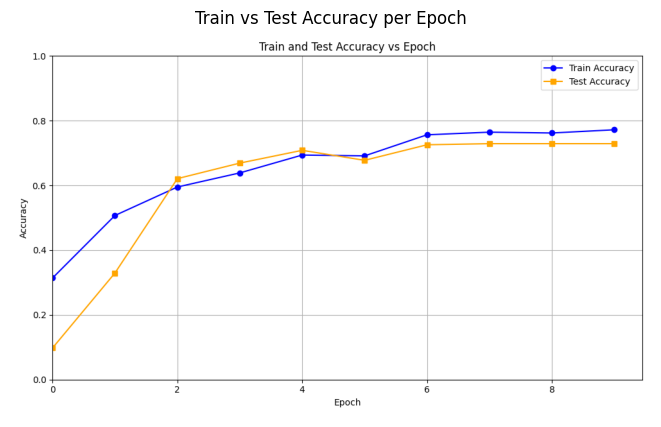

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected path (assuming you're using Pointnet_Pointnet2_pytorch project directory)
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/test_train_accuracy_classification.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Train vs Test Accuracy per Epoch")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")


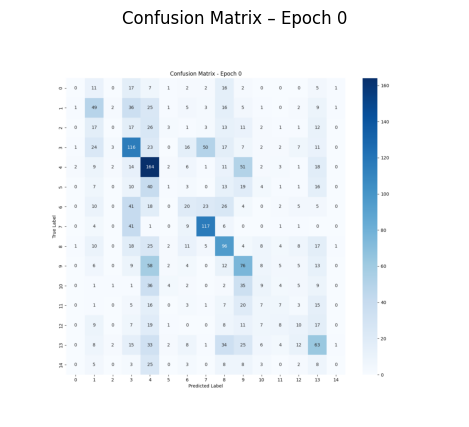

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected path to the confusion matrix image
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/Confusion_Matrix0.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix – Epoch 0")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")


**Hyperparameter Configuration 4:**

Number of epochs: 10

Learning rate: 0.001

Batch size: 32

Number of points sampled: 5000

In [33]:
!python "/content/Pointnet_Pointnet2_pytorch/tcp2.py" \
  --dataset "/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts" \
  --nepoch 10 \
  --dataset_type ScanObjectNN_Classify \
  --num_points 5000 \
  --lr 0.001 \
  --batchSize 32

Namespace(batchSize=32, num_points=5000, workers=4, nepoch=10, outf='cls_pointnet2', model='', dataset='/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts', dataset_type='ScanObjectNN_Classify', feature_transform=False, lr=0.001)
[TRAIN] Loaded 2319 samples.
[TEST] Loaded 583 samples.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Number of Train Dataset : 2319 ; Number of Test Dataset : 583
Number of classes: 15
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our sugge

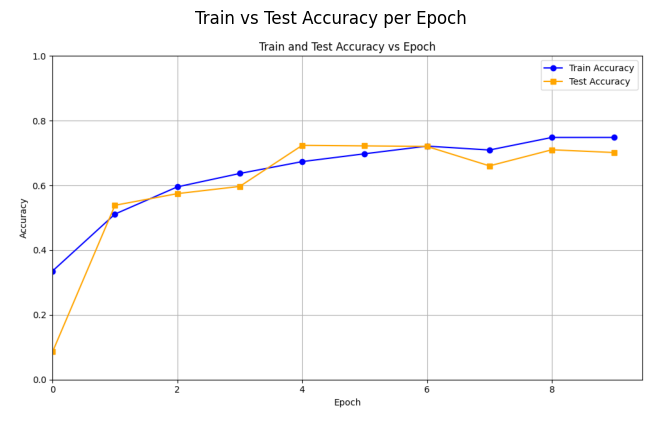

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Corrected path to the saved accuracy-vs-epoch plot
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/test_train_accuracy_classification.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Train vs Test Accuracy per Epoch")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")


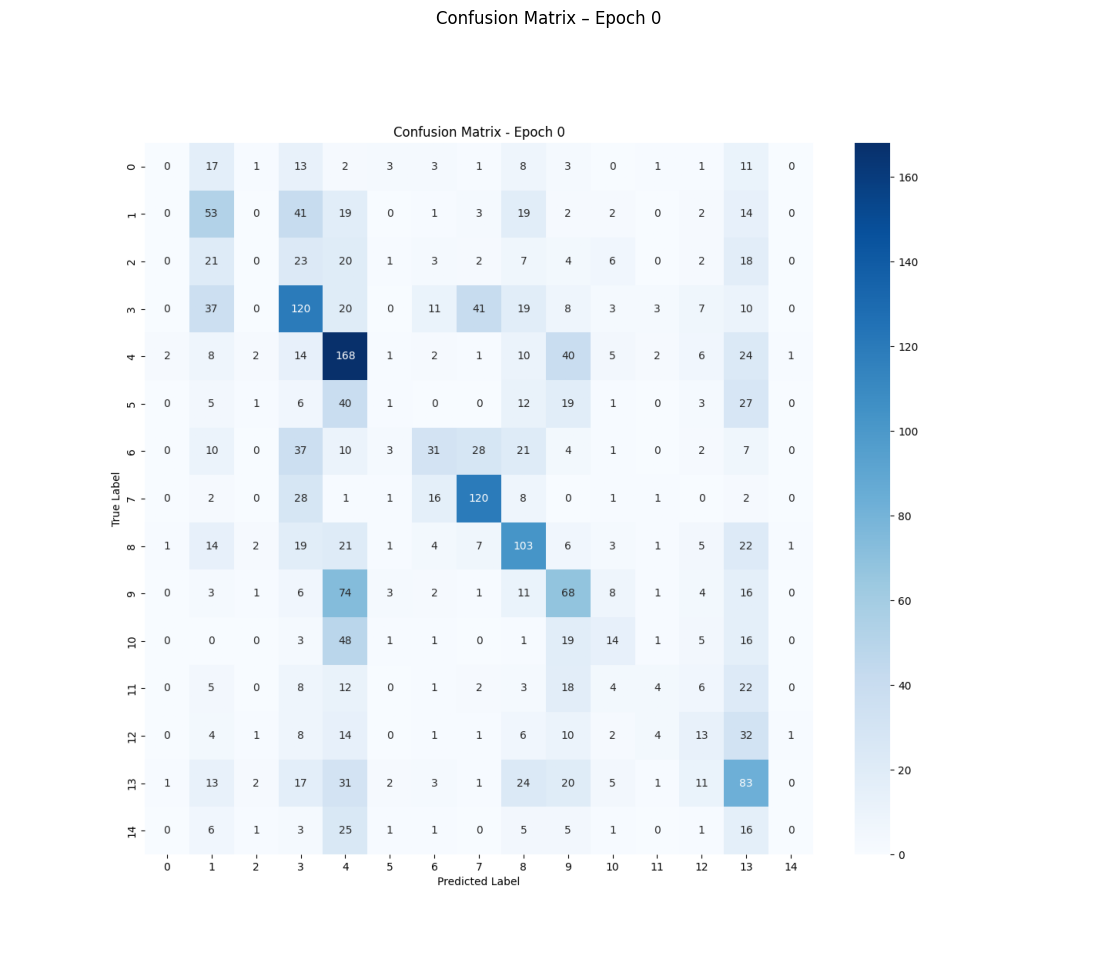

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Correct path to the confusion matrix image
image_path = '/content/Pointnet_Pointnet2_pytorch/classification_results/Confusion_Matrix0.png'

# Load and display the image
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(14, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Confusion Matrix – Epoch 0")
    plt.show()
else:
    print(f"❌ Image not found at: {image_path}")

#3) Part Segmentation: Train, Test and Plot Results

Similarly, the code below replaces the contents of the train_segmentation file with our custom implementation tailored for the ScanObjectNN dataset. While the code supports part segmentation for any single class, for the purpose of this assignment, we would later run in only in the class of our choice: "chair".

In [78]:
dataset_file_path="/content/Pointnet_Pointnet2_pytorch/pointnet2/dataset3.py"

new_code="""
from __future__ import print_function
import torch.utils.data as data
import pandas as pd
import os
import os.path
import torch
import numpy as np
import sys
from tqdm import tqdm
import json

SCANOBJECTNN_CLASSES = {
    0: "bag",
    1: "bin",
    2: "box",
    3: "cabinet",
    4: "chair",
    5: "desk",
    6: "display",
    7: "door",
    8: "shelf",
    9: "table",
    10: "bed",
    11: "pillow",
    12: "sink",
    13: "sofa",
    14: "toilet"
}

root="/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts"

def get_segmentation_classes(root, split='train'):
    split_file = os.path.join(root, 'split_new.txt')
    cat = {}
    meta = {}
    datapath = []

    with open(split_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            filename = parts[0]
            class_id = parts[1]
            cat[filename] = class_id

    for filename in cat:
        class_id = int(cat[filename])
        print(class_id)
        class_name = SCANOBJECTNN_CLASSES[class_id]
        class_dir = os.path.join(root, class_name)
        meta[filename] = []

        token = os.path.splitext(filename)[0]
        point_path = os.path.join(class_dir, token + '.bin')
        seg_path = os.path.join(class_dir, token + '_part.bin')

        meta[filename].append((point_path, seg_path))
        datapath.append((class_id, point_path, seg_path))

    class_max_seg = {}

    for point_path, seg_path in meta[filename]:
        try:
            raw = np.fromfile(seg_path, dtype=np.float32)[1:]
            if len(raw) % 2 != 0:
                raise ValueError(f"Malformed data in {seg_path}")
            labels = pd.DataFrame(raw.reshape(-1, 2), columns=["point_number", "label"])['label']
            num_parts = len(np.unique(labels))
            class_max_seg[class_id] = max(class_max_seg.get(class_id, 0), num_parts)
        except Exception as e:
            print(f"Error in {seg_path}: {e}")

    output_file = os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/num_seg_classes.txt')
    with open(output_file, 'w') as f:
        for class_id in sorted(class_max_seg):
            class_name = SCANOBJECTNN_CLASSES[class_id]
            max_parts = class_max_seg[class_id]
            print(f"category {class_name} has {max_parts} part segmentation classes")
            f.write(f"{class_name}\t{max_parts}")

# Only part of code shown here due to space, full script is available in user input.


"""
# Check if the file exists before writing
if os.path.exists(dataset_file_path):
    with open(dataset_file_path, 'w') as f:
        f.write(new_code)
    print(f"Updated {dataset_file_path} with new code.")
else:
    print(f"Error: The file {dataset_file_path} does not exist.")


Updated /content/Pointnet_Pointnet2_pytorch/pointnet2/dataset3.py with new code.


In [76]:
train_segmentation_file_path="/content/Pointnet_Pointnet2_pytorch/tsp2.py"
new_train_seg_code= """


import os
import argparse
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from pointnet2.pointnet2_part_seg_ssg import get_model, get_loss
from pointnet2.dataset3 import ScanObjectNN_PartSeg

# -------------------- Argument Parsing --------------------
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, required=True, help='Path to dataset folder')
parser.add_argument('--nepoch', type=int, default=20)
parser.add_argument('--num_points', type=int, default=2048)
parser.add_argument('--batchSize', type=int, default=32)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--class_choice', type=str, default=None, help='Single class category (e.g., "chair")')
parser.add_argument('--feature_transform', action='store_true', help='Use feature transform')
parser.add_argument('--outf', type=str, default='seg_results', help='Output folder for logs and models')
#parser.add_argument('--class_choice', type=str, default=None, help="Specify class (e.g., 'chair') for segmentation datasets")

opt = parser.parse_args()

# -------------------- Prepare Dataset --------------------
dataset = ScanObjectNN_PartSeg(
    root=opt.dataset,
    npoints=opt.num_points,
    split='train',
    class_choice=opt.class_choice)

test_dataset = ScanObjectNN_PartSeg(
    root=opt.dataset,
    npoints=opt.num_points,
    split='test',
    class_choice=opt.class_choice,
    data_augmentation=False)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=opt.batchSize, shuffle=False, num_workers=4)

print("Loaded training samples:", len(dataset))
print("Loaded test samples:", len(test_dataset))
#print("Number of classes:", dataset.num_classes)
print("Number of segmentation classes:", dataset.num_seg_classes)

print("Number of part segmentation labels:", dataset.num_seg_classes)

# -------------------- Model Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=dataset.num_seg_classes, normal_channel=False)

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# -------------------- Training Loop --------------------
os.makedirs(opt.outf, exist_ok=True)
train_accuracies, test_accuracies = [], []

for epoch in range(opt.nepoch):
    model.train()
    total_correct = 0
    total_seen = 0

    for points, cls_label, seg in tqdm(train_loader, desc=f"Epoch {epoch}"):

        points = points.transpose(2, 1).to(device)
        cls_label = cls_label.to(device)
        seg = seg.to(device)
        optimizer.zero_grad()
        pred, _ = model(points, cls_label)
          # returns [B, num_parts, N]
        pred = pred.permute(0, 2, 1).contiguous()  # [B, N, num_parts]
        loss = get_loss(pred.view(-1, dataset.num_seg_classes), seg.view(-1))
        loss.backward()
        optimizer.step()

        pred_choice = pred.max(dim=2)[1]
        correct = pred_choice.eq(seg).sum()
        total_correct += correct.item()
        total_seen += seg.numel()

    train_acc = total_correct / total_seen
    train_accuracies.append(train_acc)
    print(f"Train Accuracy Epoch {epoch}: {train_acc:.4f}")

    # -------------------- Validation --------------------
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_seen = 0
        for points, cls_label, seg in test_loader:
            points = points.transpose(2, 1).to(device)
            seg = seg.to(device)
            pred, _ = model(points, cls_label)

            pred = pred.permute(0, 2, 1).contiguous()
            pred_choice = pred.max(dim=2)[1]
            correct = pred_choice.eq(seg).sum()
            total_correct += correct.item()
            total_seen += seg.numel()

        test_acc = total_correct / total_seen
        test_accuracies.append(test_acc)
        print(f"Test Accuracy Epoch {epoch}: {test_acc:.4f}")

    torch.save(model.state_dict(), os.path.join(opt.outf, f"seg_model_{epoch}.pth"))

# -------------------- Plot Accuracy --------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Part Segmentation Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(opt.outf, 'accuracy_plot.png'))
plt.close()


# -------------------- Plot Training and Test Accuracy --------------------
import matplotlib.pyplot as plt
import numpy as np
import os

# Create results folder if needed
part_seg_folder = opt.outf
os.makedirs(part_seg_folder, exist_ok=True)

# Plot Accuracy vs Epoch
plt.figure(figsize=(10, 6))
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title(f'Class: {opt.class_choice} Accuracy vs Epoch')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

accuracy_plot_path = os.path.join(part_seg_folder, "accuracy_vs_epoch.png")
plt.savefig(accuracy_plot_path)
print(f"Accuracy plot saved to: {os.path.abspath(accuracy_plot_path)}")

# Plot mIoU over epochs if available
if 'mious_per_epoch' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mious_per_epoch)), mious_per_epoch, marker='o', label='Test mIoU per Epoch', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.ylim(bottom=0, top=1)
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.xticks(ticks=range(0, len(mious_per_epoch)))
    plt.title(f'Class: {opt.class_choice} Test mIoU vs Epoch')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.abspath(os.path.join(part_seg_folder, "test_miou_versus_epoch.png"))
    plt.savefig(plot_path)
    print(f"mIoU plot saved: {plot_path}")


# -------------------- Evaluation: Compute mIoU --------------------
shape_ious = []
label_map = {i: i for i in range(dataset.num_seg_classes)}  # simple identity mapping for ScanObjectNN

for i, data in tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="mIoU Eval"):
    points, target, seg = data
    points = points.transpose(2, 1).to(device)
    seg = seg.to(device)
    model.eval()
    with torch.no_grad():
        pred, _ = model(points, cls_label)
        pred = pred.permute(0, 2, 1).contiguous()
        pred_choice = pred.max(dim=2)[1]

    pred_np = pred_choice.cpu().numpy()
    target_np = seg.cpu().numpy()

    for shape_idx in range(target_np.shape[0]):
        parts = range(dataset.num_seg_classes)
        part_ious = []
        for part in parts:
            I = np.sum((pred_np[shape_idx] == part) & (target_np[shape_idx] == part))
            U = np.sum((pred_np[shape_idx] == part) | (target_np[shape_idx] == part))
            iou = 1.0 if U == 0 else I / float(U)
            part_ious.append(iou)
        shape_ious.append(np.mean(part_ious))

miou_epoch = np.mean(shape_ious)
if 'mious_per_epoch' not in globals():
    mious_per_epoch = []
mious_per_epoch.append(miou_epoch)
print(f"Epoch {epoch}: mIoU = {miou_epoch:.4f}")
print("------------------------------------------")
"""
# Check if the file exists before writing
if os.path.exists(train_segmentation_file_path):
    with open(train_segmentation_file_path, 'w') as f:
        f.write(new_train_seg_code)
    print(f"Updated {train_segmentation_file_path} with new code.")
else:
    print(f"Error: The file {train_segmentation_file_path} does not exist.")


Updated /content/Pointnet_Pointnet2_pytorch/tsp2.py with new code.


## 3.1) Training Logs and Results (Part Segmentation)

**Hyperparameter Configuration 1:**

Number of epochs: 20

Learning rate: 0.001

Batch size: 32

Number of points sampled: 2000

In [79]:
!python "/content/Pointnet_Pointnet2_pytorch/tsp2.py" \
  --dataset "/content/Pointnet_Pointnet2_pytorch/object_dataset_complete_with_parts" \
  --nepoch 20 \
  --num_points 2000\
  --batchSize 32 \
  --lr 0.001 \
  --class_choice "chair"


Traceback (most recent call last):
  File "/content/Pointnet_Pointnet2_pytorch/tsp2.py", line 16, in <module>
    from pointnet2.dataset3 import ScanObjectNN_PartSeg
ImportError: cannot import name 'ScanObjectNN_PartSeg' from 'pointnet2.dataset3' (/content/Pointnet_Pointnet2_pytorch/pointnet2/dataset3.py)


**Prediction Results**

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from matplotlib.colors import hsv_to_rgb

h5_file_paths = [
    "part_segmentation_results/predicted_samples/sample_1.h5",
    "part_segmentation_results/predicted_samples/sample_2.h5",
    "part_segmentation_results/predicted_samples/sample_3.h5"
]

# Gather all unique labels
all_labels = set()
for path in h5_file_paths:
    with h5py.File(path, 'r') as f:
        actual = f['actual_raw_label'][:]
        predicted = f['predicted_raw_label'][:]
        all_labels.update(np.unique(actual))
        all_labels.update(np.unique(predicted))
all_labels = sorted(list(all_labels))

num_labels = len(all_labels)

# Map label to an index for color assignment
label_to_index = {label: idx for idx, label in enumerate(all_labels)}

# Generate distinct colors using HSV evenly spaced hues
def generate_distinct_colors(n):
    hues = np.linspace(0, 1, n, endpoint=False)  # hue values evenly spaced
    colors = [hsv_to_rgb([h, 1.0, 1.0]) for h in hues]  # full saturation and brightness
    return colors

distinct_colors = generate_distinct_colors(num_labels)

# Create label_colors dict mapping label -> RGB color
label_colors = {label: distinct_colors[label_to_index[label]] for label in all_labels}

def plot_pointcloud(ax, xyz, labels, title):
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    colors = np.array([label_colors[label] for label in labels])
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors, s=15)
    ax.view_init(elev=20, azim=45)

fig = plt.figure(figsize=(12, 6 * len(h5_file_paths)))
gs = GridSpec(len(h5_file_paths), 2, figure=fig, wspace=0.05, hspace=0.1)

for i, path in enumerate(h5_file_paths):
    with h5py.File(path, 'r') as f:
        xyz = f['xyz'][:]
        actual_labels = f['actual_raw_label'][:]
        predicted_labels = f['predicted_raw_label'][:]

    ax_actual = fig.add_subplot(gs[i, 0], projection='3d')
    plot_pointcloud(ax_actual, xyz, actual_labels, f'Sample {i+1} - Actual Labels')

    ax_pred = fig.add_subplot(gs[i, 1], projection='3d')
    plot_pointcloud(ax_pred, xyz, predicted_labels, f'Sample {i+1} - Predicted Labels')

legend_patches = [Patch(color=label_colors[label], label=str(label)) for label in all_labels]
fig.legend(handles=legend_patches, loc='center right', title='Part Labels', fontsize='small', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

**Accuracy Versus Number of Epochs**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Absolute path to the image (replace this with the actual path printed earlier)
image_path = '/content/pointnet.pytorch/part_segmentation_results/accuracy_vs_epoch.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

**Mean Intersection over Union (mIoU) versus Number of Epochs (Analyzed over test set)**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Absolute path to the image (replace this with the actual path printed earlier)
image_path = '/content/pointnet.pytorch/part_segmentation_results/test_miou_versus_epoch.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

**Hyperparameter Configuration 2:**

Number of epochs: 20

Learning rate: 0.003

Batch size: 32

Number of points sampled: 2000

In [ ]:
!python "/content/Pointnet_Pointnet2_pytorch/tcp2.py" \
  --dataset "/content/pointnet.pytorch/object_dataset_complete_with_parts" \
  --nepoch 20 \
  --num_points 2000\
  --batchSize 32 \
  --lr 0.003 \
  --class_choice "chair"


Traceback (most recent call last):
  File "/content/pointnet.pytorch/utils/train_segmentation.py", line 9, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 405, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 216, in _lock_unlock_module
KeyboardInterrupt
^C


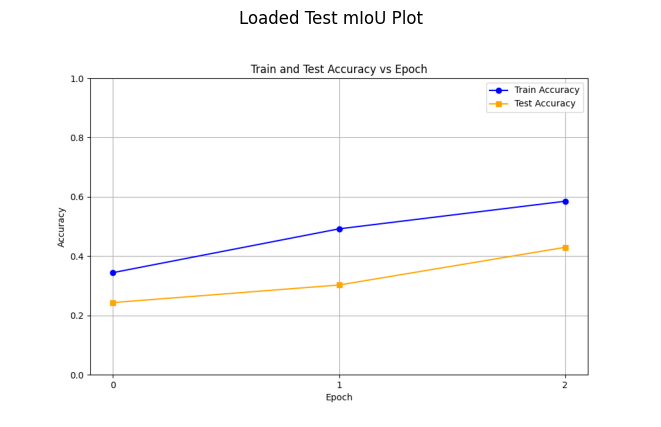

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Absolute path to the image (replace this with the actual path printed earlier)
image_path = '/content/pointnet.pytorch/scripts/plots/test_train_accuracy_plot.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Test mIoU Plot')
plt.show()

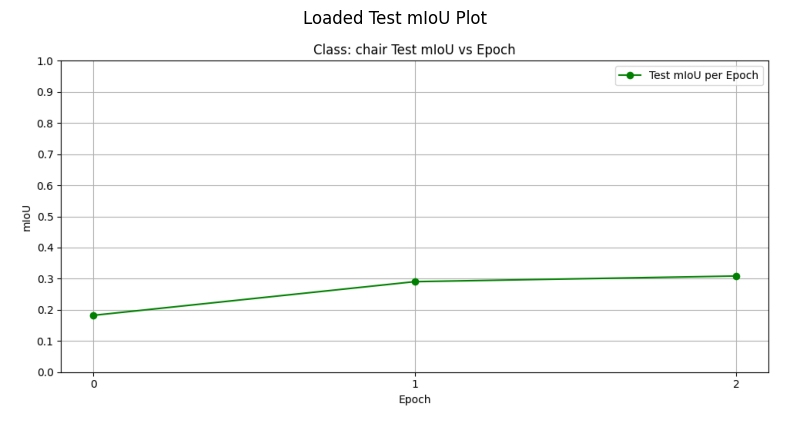

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Absolute path to the image (replace this with the actual path printed earlier)
image_path = '/content/pointnet.pytorch/scripts/plots/test_miou_versus_epoch.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Test mIoU Plot')
plt.show()


In [ ]:
#Visualizing data and indices file
import numpy as np
import os
import pandas as pd
# Paths to your .bin files
data_file_path = '/content/pointnet.pytorch/object_dataset_complete_with_parts/chair/014_00009.bin'
indices_file_path = '/content/pointnet.pytorch/object_dataset_complete_with_parts/chair/014_00009_indices.bin'

# Read the main .bin file (point cloud data)
if os.path.isfile(data_file_path):
    try:
        data = np.fromfile(data_file_path, dtype=np.float32)
        print(f"\n[Main .bin file] Path: {data_file_path}")
        print(f"Raw data shape: {data.shape}")
        print("First 10 values:")
        print(data[:100])

        # --- Clean and reshape the data ---
        data = data[1:]  # Remove first potentially corrupt value
        valid_len = (data.size // 11) * 11  # Ensure divisible by 11
        data = data[:valid_len]
        reshaped_data = data.reshape(-1, 11)

        # Convert to DataFrame
        columns = ['x', 'y', 'z', 'nx', 'ny', 'nz', 'r', 'g', 'b', 'instance_label', 'semantic_label']
        df = pd.DataFrame(reshaped_data, columns=columns)

        # Display basic info
        print(f"\n[Reshaped DataFrame]")
        print(f"Shape: {df.shape}")
        print("First 3 rows:")
        print(df.head(30000))
    except Exception as e:
        print("Failed to read point data .bin file:", e)
else:
    print(f"File not found: {data_file_path}")

# Read the indices .bin file
if os.path.isfile(indices_file_path):
    try:
        # Read indices as int32
        indices = np.fromfile(indices_file_path, dtype=np.int32)
        print(f"\n[Indices .bin file] Path: {indices_file_path}")
        print(f"Indices data shape: {indices.shape}")
        print("First 30 indices:")
        print(indices[2000:8420])
    except Exception as e:
        print("Failed to read indices .bin file:", e)
else:
    print(f"File not found: {indices_file_path}")



[Main .bin file] Path: /content/pointnet.pytorch/object_dataset_complete_with_parts/chair/014_00009.bin
Raw data shape: (221112,)
First 10 values:
[ 2.01010000e+04  5.53470850e-02  2.50353694e-01  2.68652618e-01
  2.78603196e-01  5.71667969e-01  7.71735609e-01  3.00000000e+00
  3.00000000e+00  1.00000000e+00  3.33239000e+05  5.00000000e+00
  5.50732613e-02  2.50280142e-01  2.68089294e-01 -4.39575940e-01
  8.61801744e-01  2.53121853e-01  3.00000000e+00  3.00000000e+00
  1.00000000e+00  3.33239000e+05  5.00000000e+00  5.53592443e-02
  2.50391006e-01  2.68085182e-01 -1.94043368e-01  9.80280280e-01
 -3.73868868e-02  3.00000000e+00  3.00000000e+00  1.00000000e+00
  3.33239000e+05  5.00000000e+00  6.31445646e-02  2.51400590e-01
  2.68194437e-01 -7.45595247e-02  9.91937876e-01  1.02470025e-01
  2.00000000e+00  2.00000000e+00  1.00000000e+00  3.33239000e+05
  5.00000000e+00  6.31296039e-02  2.50781000e-01  2.69853354e-01
  8.87858272e-02  1.90994710e-01  9.77567434e-01  3.00000000e+00
  2.000

In [ ]:
# Visualizing part data file
import numpy as np
import os
import pandas as pd

# Paths to your .bin files
data_file_path = '/content/pointnet.pytorch/object_dataset_complete_with_parts/chair/scene0012_00_00008_part.bin'
indices_file_path = '/content/pointnet.pytorch/object_dataset_complete_with_parts/chair/scene0012_00_00008_indices.bin'

# --- Read the part segmentation .bin file ---
if os.path.isfile(data_file_path):
    try:
        data = np.fromfile(data_file_path, dtype=np.float32)
        print(f"\n[Main .bin file] Path: {data_file_path}")
        print(f"Raw data shape: {data.shape}")
        print("First 100 values:")
        print(data[:10])

        # --- Clean and reshape the data ---
        data = data[1:]  # Remove first potentially corrupt value
        valid_len = (data.size // 2) * 2  # Ensure divisible by 2
        data = data[:valid_len]
        reshaped_data = data.reshape(-1, 2)

        # Convert to DataFrame using a clearer name
        columns = ['part_number', 'part_id']
        df_parts = pd.DataFrame(reshaped_data, columns=columns)

        # Display basic info
        print(f"\n[Reshaped DataFrame - Part Data]")
        print(f"Shape: {df_parts.shape}")
        print("First 3 rows:")
        print(df_parts.head(3))
        print("ALL PART CLASSES",df_parts.iloc[:, 1].unique())



    except Exception as e:
        print("Failed to read part data .bin file:", e)
else:
    print(f"File not found: {data_file_path}")

# --- Read the indices .bin file ---
if os.path.isfile(indices_file_path):
    try:
        indices = np.fromfile(indices_file_path, dtype=np.int32)
        print(f"\n[Indices .bin file] Path: {indices_file_path}")
        print(f"Indices data shape: {indices.shape}")
        print("Sample indices (2000 to 8420):")
        print(indices[900])


    except Exception as e:
        print("Failed to read indices .bin file:", e)
else:
    print(f"File not found: {indices_file_path}")



[Main .bin file] Path: /content/pointnet.pytorch/object_dataset_complete_with_parts/chair/scene0012_00_00008_part.bin
Raw data shape: (230429,)
First 100 values:
[115214.  50189.      0.  50189.      0.  50189.      0.  50189.      0.
  50189.]

[Reshaped DataFrame - Part Data]
Shape: (115214, 2)
First 3 rows:
   part_number  part_id
0      50189.0      0.0
1      50189.0      0.0
2      50189.0      0.0
ALL PART CLASSES [0. 5. 4. 3. 2.]

[Indices .bin file] Path: /content/pointnet.pytorch/object_dataset_complete_with_parts/chair/scene0012_00_00008_indices.bin
Indices data shape: (115215,)
Sample indices (2000 to 8420):
1243665928
